# Week 9: Clustering of Masaeli et al.

We're going to reimplement an SVM model from a [Di Carlo lab's study of the mechanical properties of cells](https://www.nature.com/articles/srep37863). With this, we'll then explore some of its properties.

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA, NMF
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale,  StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC # "Support vector classifier"

warnings.filterwarnings("ignore")


mat = pd.read_csv('WBC.csv')
mat.drop('Unnamed: 0', axis=1, inplace=True)

#### (1) Choose any two variables and plot them against cell identity (in color). Do you see clear separation of these classes? What does this tell you about whether or not you can classify the cells of differing type?

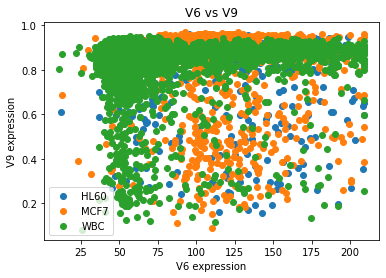

In [3]:
# Answer

sample = mat.loc[:,['Sample']]
v1 = mat.loc[:,['V1']]
samplelist = mat['Sample'].tolist()
celltypes = set(samplelist)
for i in celltypes:
    cellMat = mat.loc[mat["Sample"].isin([i]),:]
    v1 = cellMat.loc[:,['V6']]
    v2 = cellMat.loc[:,['V9']]
    plt.scatter(v1,v2, label = str(i))
plt.legend()
plt.title("V6 vs V9")
plt.xlabel("V6 expression")
plt.ylabel("V9 expression");

No clear separation is seen betwenen classes, looks like the points are all on top of each other. You can't classify cells of differing type based on this plot, no sir.

#### (2) Use principal components analysis to visualize the variation in each variable. Plot the first two principal components against the cell type. Do you see better separation in this case? What does this tell you about your ability to distinguish the cell types?

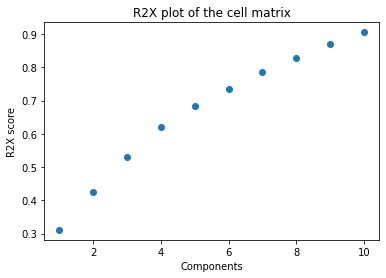

HL60
MCF7
WBC


Text(0, 0.5, 'Component 2')

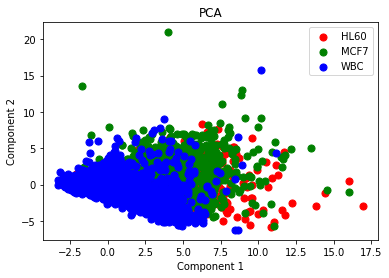

In [4]:
# Answer
from scipy import stats

r2x = 0
n = 1
r2xplot = []
X = mat.iloc[:,0:-1]

X = X.to_numpy()
X = scale(X)
Y = mat.iloc[:,-1]

while(r2x < 0.9):
    pca = PCA(n_components = n)
    X_r = pca.fit_transform(X)
    
    r2x = sum(pca.explained_variance_ratio_)
    r2xplot.append(r2x)
    n+=1
xaxis = list(range(1,1+len(r2xplot)))
plt.scatter(xaxis,r2xplot)
plt.title("R2X plot of the cell matrix")
plt.ylabel("R2X score")
plt.xlabel("Components")
plt.show()
targets = list(celltypes)

color = ['r','g','b']
for target, color in zip(targets, color):
    print(target)
    mask = Y == target
    plt.scatter(X_r[mask,0],X_r[mask,1], c = color, s = 50, label = str(target))
plt.legend()
plt.title("PCA")
plt.xlabel("Component 1")
plt.ylabel("Component 2")


The points are still mostly ontop of each other, so similar to before, we can't really distinguish the cell types as the cell separation is not there. 2 components not enough or can't properly show separation. Much more than 2 are needed for high R2X (10 for 90%).

#### (3) How does partial least squares regression fare in discriminating cancer and non-cancer cells (make cancer=1 and non-cancer=0; this is called PLS-DA)? How does this relate to the results in the previous questions?

In [5]:
# Answer

nmat = mat.copy()

nmat.loc[:,"cancer"] = np.ones(nmat.shape[0])
nmat.loc[nmat["Sample"] == 'WBC', "cancer"] = 0
nmat = nmat.drop(columns = ["Sample"])
X1 = nmat.iloc[:,0:-1].to_numpy()
X1 = StandardScaler().fit_transform(X1)
Y1 = nmat.iloc[:,-1].to_numpy()

nmat1 = mat.copy()
nmat1.loc[:,"class"] = np.ones(nmat1.shape[0])
nmat1.loc[nmat1["Sample"] == 'WBC', "class"] = 0
nmat1.loc[nmat1["Sample"] == 'MCF7', "class"] = 1
nmat1.loc[nmat1["Sample"] == 'HL60', "class"] = 2
X_WBC = nmat1.loc[nmat1["class"].isin([0]),:]
X_MC = nmat1.loc[nmat1["class"].isin([1]),:]
X_HL = nmat1.loc[nmat1["class"].isin([2]),:]


Y_WBC = X_WBC["class"].to_numpy()
Y_MC = X_MC["class"].to_numpy()
Y_HL = X_HL["class"].to_numpy()


X_WBC = X_WBC.drop(columns = ["Sample","class"]).to_numpy()
X_MC = X_MC.drop(columns = ["Sample","class"]).to_numpy()
X_HL = X_HL.drop(columns = ["Sample","class"]).to_numpy()

X_MCHL = np.concatenate((X_MC,X_HL), axis = 0)
Y_MCHL = np.concatenate((Y_MC,Y_HL), axis = 0)


# X_WBC_test = nmat1.loc[nmat1["Sample"].isin(["WBC"]),:].to_numpy()
# print(X_WBC)
# print(X_WBC_test)

Prediction accuracy using plsr_score without thresholding: 0.6717032046288665
Prediction accuracy of PLSDA with thresholding: 0.9588444796201029
PLSDA accuracy without thresholding
Tested within sample based on cross validation
[0.6561178190931232, 0.6927593993000764, 0.677371986545854, 0.6817975156963565, 0.6427237662250461]
PLSDA accuracy with thresholding
Tested within sample based on cross validation
[0.9589515331355094, 0.9574678536102869, 0.9584569732937686, 0.962889658584859, 0.9574468085106383]


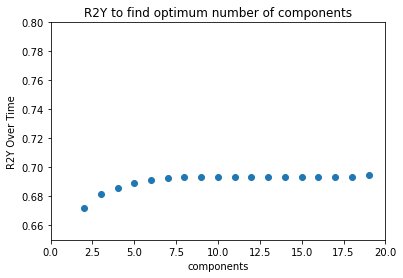

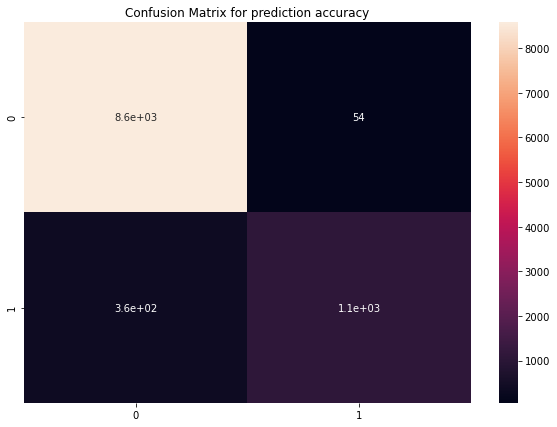

In [6]:
from sklearn.metrics import accuracy_score
y = []
r2y = 0
n = 1
plsr = PLSRegression(n_components = 2)
fit = plsr.fit_transform(X1,Y1)
r2y = plsr.score(X1,Y1)
print("Prediction accuracy using plsr_score without thresholding: " + str(r2y))


while(n<20):
    plsr = PLSRegression(n_components = n)
    fit = plsr.fit_transform(X1,Y1)
    r2y = plsr.score(X1,Y1)
    y.append(r2y)
    n+=1

x = list(range(1,1+ len(y)))

plt.scatter(x,y)
plt.xlim(0,20)
plt.ylim(0.65,.8)
plt.xlabel('components')
plt.ylabel('R2y');
plt.ylabel('R2Y Over Time')
plt.title('R2Y to find optimum number of components')

#PLSDA Confusion Matrix stuff

plsr = PLSRegression(n_components = 2)
fit = plsr.fit_transform(X1,Y1)
r2y = plsr.score(X1,Y1)
y_pred = plsr.predict(X1)

y_pred[y_pred < 0.5] = 0
y_pred[y_pred > 0.5] = 1


accuracy = accuracy_score(Y1, y_pred)

print("Prediction accuracy of PLSDA with thresholding: " + str(accuracy))
cm = confusion_matrix(Y1, y_pred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot = True)
plt.title("Confusion Matrix for prediction accuracy")




X_few = X1
Y_few = Y1

print("PLSDA accuracy without thresholding")
skf = StratifiedKFold(n_splits = 5, shuffle = True)
y_scoresK = []
y_scoresActual = []
for train_index, test_index in skf.split(X_few,Y_few):
    train_X, test_X = X_few[train_index], X_few[test_index]
    train_Y,test_Y = Y_few[train_index], Y_few[test_index]
    
    plsr = PLSRegression(n_components = 2)
    fit = plsr.fit_transform(train_X,train_Y)
    r2y = plsr.score(test_X,test_Y)
    y_scoresK.append(r2y)
print("Tested within sample based on cross validation")
print(y_scoresK)

print("PLSDA accuracy with thresholding")
skf = StratifiedKFold(n_splits = 5, shuffle = True)
y_scoresK = []
y_scoresActual = []
for train_index, test_index in skf.split(X_few,Y_few):
    train_X, test_X = X_few[train_index], X_few[test_index]
    train_Y,test_Y = Y_few[train_index], Y_few[test_index]
    
    plsr = PLSRegression(n_components = 2)
    fit = plsr.fit_transform(train_X,train_Y)
    y_pred = plsr.predict(test_X)
    y_pred[y_pred < 0.5] = 0
    y_pred[y_pred > 0.5] = 1
    
    accuracy = accuracy_score(test_Y, y_pred)
    y_scoresK.append(accuracy)
print("Tested within sample based on cross validation")
print(y_scoresK)



Based on r2y we see it's not possible to achieve even over 90% for r2y. Based on number 2, it doesn't seem like clustering is very effective. Without thresholding, plsr will only get about 67% accuracy whereas with thresholding we get roughly 95% prediction accuracy. As shown in the confusion matrix, there is still a sizable number of points that are in the incorrect area. With thresholding the accuracy is pretty good at 95%, but as we have seen, it is difficult to see any thresholding (so PLSDA may not necessarily work very well here).

##### (4) Setup a support vector machine classifier (with linear kernel) to distinguish cancer and non-cancer.

Evaluate how well this performs.

In [7]:
# Answer
from sklearn import svm
from sklearn.metrics import accuracy_score
model = svm.LinearSVC()
model.fit(X1, Y1)
print("SVM Prediction Accuracy: " + str(model.score(X1,Y1)))
y_pred = model.predict(X1)
# y_pred = model.predict(X1)
# accuracy = accuracy_score(Y1.flatten(), y_pred)
# print(accuracy)


SVM Prediction Accuracy: 0.9701226751088247


Prediction is higher than PLSDA and all the other tests we ran earlier.

#### (5) Choose and justify your selection of a different kernel to use in SVM classification. (Hint: It should be a kernel with varying complexity, such as polynomial or RBF.)

In [8]:
# Answer

from sklearn.svm import SVC
from sklearn.datasets.samples_generator import make_circles
from sklearn.datasets import make_blobs
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d
kernel_type = ['linear', 'rbf', 'poly']

for kernel in kernel_type:
    model = SVC(kernel = kernel)
    model.fit(X1,Y1)
    print("Prediction Accuracy for " + kernel+" " + str(model.score(X1,Y1)))

print('As shown the kernel that allows for the highest prediction accuracy would be\nthe RBF kernel')




Prediction Accuracy for linear 0.970815195884448
Prediction Accuracy for rbf 0.9818955282944203
Prediction Accuracy for poly 0.9810051444400475
As shown the kernel that allows for the highest prediction accuracy would be
the RBF kernel


In [9]:
# model = SVC(kernel = 'rbf')
# model.fit(X1,Y1)
# model.score(X1,Y1)

#### (6) Vary the complexity of your kernel and evaluate the ability of it to descriminate data both directly and on cross-validation.

How does the answer of which classification strategy vary based on whether you are performing cross-validation?

In [12]:
# Answer
from sklearn.model_selection import StratifiedKFold
gammaS = 1/11*X1.var()
print("Scaled Gamma Value: " + str(gammaS))

gammaVariation = np.logspace(-15, 0, 4)
print("Gamma set tested: " + str(gammaVariation))
scores = []
for gamma in gammaVariation:
    clf = SVC(kernel = 'rbf', C = 1E6, gamma = gamma)
    clf.fit(X1,Y1)
    scores.append(clf.score(X1,Y1))
print("Directly Testing Prediction Accuracies, Gamma: " + str(gammaVariation))
print(scores)

# skf = StratifiedKFold(n_splits = 5, shuffle = True)
# y_scoresK = []
# for train_index, test_index in skf.split(X1,Y1):
#     train_X, test_X = X1[train_index], X1[test_index]
#     train_Y,test_Y = Y1[train_index], Y1[test_index]
#     clf = svm.SVC(kernel = 'rbf', C=1E6, gamma = gammaVariation[2])
#     clf.fit(train_X,train_Y)
#     y_scoresK.append(clf.score(test_X, test_Y))
# print(y_scoresK)

Scaled Gamma Value: 0.09090909090909093
Gamma set tested: [1.e-15 1.e-10 1.e-05 1.e+00]
Directly Testing Prediction Accuracies, Gamma: [1.e-15 1.e-10 1.e-05 1.e+00]
[0.8536802532647408, 0.8904827859121488, 0.9742777997625643, 1.0]


In [11]:
#stratified kfold

for gamma in gammaVariation:
    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    y_scoresK = []
    for train_index, test_index in skf.split(X1,Y1):
        train_X, test_X = X1[train_index,:], X1[test_index,:]
        train_Y,test_Y = Y1[train_index], Y1[test_index]
        clf = SVC(kernel = 'rbf', C=1E6, gamma = gamma)
        clf.fit(train_X,train_Y)
        y_scoresK.append(clf.score(test_X, test_Y))
    print("Cross Validation Testing Prediction Accuracies, Gamma: " + str(gamma))
    print(y_scoresK)
    

# plt.scatter(X1[:,6], X1[:,8], c = Y1, s = 50, cmap = 'autumn')
# plot_svc_decision_function(clf)
# plt.scatter(clf.support_vectors_[:,6], clf.support_vectors_[:,8], s = 300, lw = 1, facecolors = 'none');

Cross Validation Testing Prediction Accuracies, Gamma: 1e-15
[0.8536102868447082, 0.8536102868447082, 0.8536102868447082, 0.8540326571004453, 0.8535378525482434]
Cross Validation Testing Prediction Accuracies, Gamma: 1e-10
[0.8976261127596439, 0.9085064292779427, 0.8991097922848664, 0.8837209302325582, 0.8921326076199901]
Cross Validation Testing Prediction Accuracies, Gamma: 1e-05
[0.9752720079129574, 0.9688427299703264, 0.9688427299703264, 0.9708065314200891, 0.9732805541810985]
Cross Validation Testing Prediction Accuracies, Gamma: 1.0
[0.8818001978239367, 0.887240356083086, 0.8892185954500494, 0.8847105393369619, 0.88421573478476]


Varying gamma (inverse of the radius of the rbf kernel) will vary the complexity of the kernel.
Based on directly testing vs. cross validation, we can see that there are higher prediction accuracies when directly testing rather than cross validation which makes sense since training data is a smaller subset of the entire data with CV whereas in driectly testing, we have the entire data set to train with. 

Testing with cross validation also shows that there is a bell curve for the gamma values in which it is optimized at a certain peak before it drops back down. In the above, only 4 gammas were tested but you can see that it peaks at 97%.

#### (7) Your experimental collaborator asks you to determine whether she can collect a fewer number of measurements (cells) and still obtain the same classification efficiency when building a new estimator. How might you determine this? Can she?

In [11]:
# Answer



kept_values = np.linspace(100,6000,10).astype(int)
print(kept_values)
for kept in kept_values:
    randnums = np.random.randint(0,10107,kept)

    X_few = X1[randnums,:]
    Y_few = Y1[randnums]

    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    y_scoresK = []
    y_scoresActual = []
    for train_index, test_index in skf.split(X_few,Y_few):
        train_X, test_X = X_few[train_index], X_few[test_index]
        train_Y,test_Y = Y_few[train_index], Y_few[test_index]
        clf = SVC(kernel = 'rbf', C=1E6, gamma = gammaS)
        clf.fit(train_X,train_Y)
        y_scoresK.append(clf.score(test_X, test_Y))
        y_scoresActual.append(clf.score(X1,Y1))
    print("Samples used: " + str(kept))
    print("Tested within sample based on cross validation")
    print(y_scoresK)
    print("Tested across entire data set with the training set from cross validation (not that useful, but thought I'd check)")
    print(y_scoresActual)


[ 100  755 1411 2066 2722 3377 4033 4688 5344 6000]
Samples used: 100
Tested within sample based on cross validation
[1.0, 0.9, 1.0, 0.9, 0.95]
Tested across entire data set with the training set from cross validation (not that useful, but thought I'd check)
[0.9346062524732884, 0.9095765730114761, 0.9302532647407994, 0.910763751483973, 0.9158092599920855]
Samples used: 755
Tested within sample based on cross validation
[0.9337748344370861, 0.9271523178807947, 0.9337748344370861, 0.8940397350993378, 0.9337748344370861]
Tested across entire data set with the training set from cross validation (not that useful, but thought I'd check)
[0.9609220419469727, 0.9400474871388999, 0.9286703601108033, 0.94400474871389, 0.9299564701226751]
Samples used: 1411
Tested within sample based on cross validation
[0.9717314487632509, 0.9680851063829787, 0.9787234042553191, 0.9822695035460993, 0.9645390070921985]
Tested across entire data set with the training set from cross validation (not that useful, bu

As shown classification efficiency is over 95 by the time we are past 500 samples, so it seems like anything over that will be good and pushing closer to over 5000 will give a consistent sample prediction accuracy of over 97% using checking with cross validation.

#### (8) What if you can change the numbers of individual cell types that you collect? Is the model you obtain sensitive to the number of cells in each group to the same extent? Try this with one cell population.

In [17]:
# Answer
from sklearn.utils import resample
gammaS = 1E-5
print(X_WBC.shape)
print(Y_WBC.shape)
matrix_total = np.column_stack((X_WBC, Y_WBC))
matrix_total_MCHL = np.column_stack((X_MCHL,Y_MCHL))





(8629, 19)
(8629,)


In [14]:
print("CHANGING WBCs")
amounts = np.linspace(1000,X_WBC.shape[0]-1,5).astype(int)

for amount in amounts:
    i_WBC = np.linspace(0,X_WBC.shape[0]-1,X_WBC.shape[0]-1).astype(int)

    i_WBC = resample(i_WBC, n_samples=amount, replace = False)
#     X_WBC_resamp = X_WBC[i_WBC]
#     Y_WBC_resamp = Y_WBC[i_WBC]
   
    resamp_matrix = resample(matrix_total, n_samples = amount, replace = False)
    X_WBC_resamp = scale(resamp_matrix[:,:-1])
    Y_WBC_resamp = resamp_matrix[:,-1]

    
    X_modified = np.concatenate((X_WBC_resamp,X_MCHL),axis = 0)
    Y_modified = np.concatenate((Y_WBC_resamp, Y_MCHL), axis = 0)

    X_few = scale(X_modified)
    Y_few = Y_modified
    
#     clf = svm.SVC(kernel = 'rbf')
#     clf.fit(X_few,Y_few)
#     y_scoresK.append(clf.score(X_few, Y_few))

    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    y_scoresK = []
    y_scoresActual = []
    for train_index, test_index in skf.split(X_few,Y_few):
        train_X, test_X = X_few[train_index,:], X_few[test_index,:]
        train_Y,test_Y = Y_few[train_index], Y_few[test_index]
        clf = SVC(kernel = 'rbf')
        clf.fit(train_X,train_Y)
        y_scoresK.append(clf.score(test_X, test_Y))
#         y_scoresActual.append(clf.score(X1,Y1))
    print("WBCs kept: " + str(X_WBC_resamp.shape[0]))
    print("Using test set from cross validation: " + str(y_scoresK))
#     print("Using test set from entire dataset: " + str(y_scoresActual))
    

CHANGING WBCs
WBCs kept: 1000
Using test set from cross validation: [0.8810483870967742, 0.8770161290322581, 0.8770161290322581, 0.8729838709677419, 0.8707070707070707]
WBCs kept: 2907
Using test set from cross validation: [0.928246013667426, 0.9315849486887116, 0.9315849486887116, 0.9247434435575826, 0.9258836944127709]
WBCs kept: 4814
Using test set from cross validation: [0.9515488482922955, 0.9523431294678316, 0.9467831612390787, 0.9483306836248012, 0.9562798092209857]
WBCs kept: 6721
Using test set from cross validation: [0.9634146341463414, 0.9646341463414634, 0.9664634146341463, 0.9597560975609756, 0.9658536585365853]
WBCs kept: 8628
Using test set from cross validation: [0.9693372898120672, 0.9683481701285855, 0.9698169223156853, 0.9737753587333003, 0.9708065314200891]


In [18]:
print("CHANGING MCF7/HL60s")
amounts = np.linspace(200,X_MCHL.shape[0]-1,5).astype(int)
for amount in amounts:
    i_WBC = np.linspace(0,X_MCHL.shape[0]-1,X_MCHL.shape[0]-1).astype(int)

    i_WBC = resample(i_WBC, n_samples=amount, replace = False)
#     X_WBC_resamp = X_MCHL[i_WBC]
#     Y_WBC_resamp = Y_MCHL[i_WBC]

    resamp_matrix = resample(matrix_total_MCHL, n_samples = amount, replace = False)
    X_WBC_resamp = scale(resamp_matrix[:,:-1])
    Y_WBC_resamp = resamp_matrix[:,-1]
    
    X_modified = np.concatenate((X_WBC_resamp,X_WBC),axis = 0)
    Y_modified = np.concatenate((Y_WBC_resamp, Y_WBC), axis = 0)

    
    X_few = scale(X_modified)
    Y_few = Y_modified

    
#     clf = svm.SVC(kernel = 'rbf')
#     clf.fit(X_few,Y_few)
#     y_scoresK.append(clf.score(X_few, Y_few))

    skf = StratifiedKFold(n_splits = 5, shuffle = True)
    y_scoresK = []
    y_scoresActual = []
    for train_index, test_index in skf.split(X_few,Y_few):
        train_X, test_X = X_few[train_index], X_few[test_index]
        train_Y,test_Y = Y_few[train_index], Y_few[test_index]
        clf = SVC(kernel = 'rbf')
        clf.fit(train_X,train_Y)
        y_scoresK.append(clf.score(test_X, test_Y))
#         y_scoresActual.append(clf.score(X1,Y1))
    print("MCF7/HL60s resampled: " + str(X_WBC_resamp.shape[0]))
    print("Using test set from cross validation: " + str(y_scoresK))
#     print("Using test set from entire dataset: " + str(y_scoresActual))
    

CHANGING MCF7/HL60s
MCF7/HL60s resampled: 200
Using test set from cross validation: [0.9943374858437146, 0.992638731596829, 0.9932049830124575, 0.9909399773499433, 0.9926345609065156]
MCF7/HL60s resampled: 519
Using test set from cross validation: [0.9896174863387979, 0.9868852459016394, 0.9879781420765027, 0.9890650628758885, 0.985784581738655]
MCF7/HL60s resampled: 839
Using test set from cross validation: [0.981520591341077, 0.9794086589229145, 0.9809926082365364, 0.9804543053354464, 0.9825673534072901]
MCF7/HL60s resampled: 1158
Using test set from cross validation: [0.9759959141981613, 0.9780388151174668, 0.9754726622381196, 0.9759836484414921, 0.9775166070516096]
MCF7/HL60s resampled: 1478
Using test set from cross validation: [0.9718100890207715, 0.9757665677546983, 0.9703117268678871, 0.9698169223156853, 0.9683325086590797]


As shown, changing the number of WBCs (re)sampled had a slight effect on the prediction accuracy. I think having more samples allows us to more properly find those support vector points. If those are missing they can change the prediction accuracy for better or for worse. That's why when we increase MCF7/HL60s sampling, the prediction accuracy eventually drops. So it's not necessarily sensitive based on having more points will weight one more, but rather whether there are sufficient points to properly represent the population. Additionally, it's possible the data model could not be performing well with smaller samples and is instead getting a higher prediction accuracy because there are more points that are 0s so it could be assigning them to 0 when checking accuracy score independent of how correct they are (so getting lucky).

#### (9) You want to save your fit model, but want to reduce it so that you don't have to carry around all the data points. Which points could you remove and still have the same SVM model in the end?

Answer

I think the main thing to take into consideration or remember is that SVM does not fit with respect to certain variables, rather it depends on the points that are the support vectors. So theoretically if we could find those points, we need to make sure to keep them around and maybe remove some of the points in the outer edges as we already know the conclusion that will take place for those points. But for the ones that make up the support vector and are close to the decision boundary, those need to be maintained to get the same result as those are the closest in similarity with each other

#### (10) Your collaborator collects completely new data and brings it to you for classification. You take your chosen optimal model from (7) and classify each cell. Would you expect your model to perform better, identically, or worse than before? Why?

# Answer 
Short answer

This is mainly because we trained solely on our own data set. Given that we also did cross validation, it's possible based on the data that if it is representative of the whole, we could also perform better as CV often overestimates prediction error and underestimates prediction accuracy. Thus, we would expect the model to perform better. ***If it's new data based on the chosen optimal model I would not be surprised if the model performed worse. 

#### (11) As a prior distribution, assume that, among patients coming in for testing, 99% are cancer-free in the end. Estimate how well your assay needs to perform for 90% of positive tests to in fact have cancer.

# Answer

Prior Distribution
$$ p(cancer) = 1{\%} = 0.01 \\ $$
We want an assay that gives us
$$ p(cancer|positive) = 0.9$$


Bayes Theorem:
$$ p(cancer|positive) = \frac{p(positive|cancer)p(cancer)}{p(positive)} $$
$$ p(positive) = p(positive|cancer)p(cancer) + p(positive|no cancer)p(no cancer) $$

Therefore,
$$ p(cancer|positive) = \frac{p(positive|cancer)p(cancer)}{p(positive|cancer)p(cancer) + p(positive|no cancer)p(no cancer)} $$

$$ = \frac{p(positive|cancer){\times} 0.01}{p(positive|cancer){\times} 0.01 + p(positive|no cancer){\times} 0.99} = 0.9$$

$$ 0.01p(positive|cancer) = 0.9(0.01)p(positive|cancer) + 0.9(0.99)p(positive|no cancer) \\ 0.01p(positive|cancer) = 0.009p(positive|cancer) = 0.891p(positive|no cancer) \\ 0.001p(positive|cancer) = 0.891p(positive|no cancer) \\ p(positive|cancer) = 891p(positive|no cancer) $$

TPR: p(positive|cancer)

FPR: p(positive|no cancer)

Specificity: TN/(TN+FP)

Sensitivity: TP/(FN + TP)

FNR = 1 - TPR

FPR = 1 - TNR

Thus, we expect that our assay must have a True Postive Rate (TPR) that is at least 891 times greater than its False Positive Rate (FPR) in order for 90% of positive tests to in fact have cancer